In [1]:
import jax 
from utils.train import * 
from utils.utils import *
from utils.eval import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

2023-11-01 12:26:15.274864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


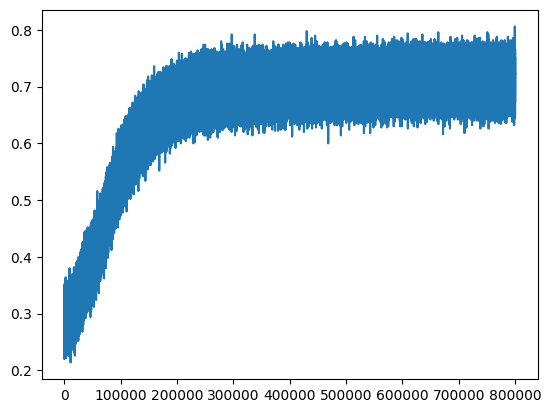

In [2]:
rewards = np.load("result/2023-11-01-SA2I-QKV-C/rewards")
plt.plot(rewards[2])

In [3]:
config = {
    "debug":True,
    "N": 5,
    "feature_dim": 3, # this the number of classes under different features set, e.g. dim = 3 for 0, 1, 2
    "emb_dim":9,
    "qkv_features":9,
    "out_features":9,
    "num_episodes": 4000000,
    "mlp_hidden": 128,
    "batch_size": 500,
    "learning_rate": 0.0001,
    "num_agents": 4,
    "PRNGkey": 0,
    "eval_PRNGkey":12345,
    "num_heads": 1,
    "eval_runs":100,
    "eps_min":0.01,
    "eps_max":0.95,
    "K":50000,
    "logging":True
    }

init_sp = jnp.zeros((config["batch_size"], 2 * config["feature_dim"]), jnp.float32)
init_h1 = jnp.zeros((config["batch_size"], config["N"], 2 * config["feature_dim"]), jnp.float32)
init_h2 = jnp.zeros((config["batch_size"], config["N"], 2 * config["feature_dim"]), jnp.float32)
init_rng = jax.random.PRNGKey(0)


hinter = A2ICoded(hidden=config["mlp_hidden"],
                 num_heads=config["num_heads"],
                 batch_size=config["batch_size"],
                 emb_dim=config["emb_dim"],
                 N=config["N"],
                 qkv_features=config["qkv_features"],
                 out_features=config["out_features"])
        
        
        
guesser = A2ICoded(hidden=config["mlp_hidden"],
				num_heads=config["num_heads"],
				batch_size=config["batch_size"],
				emb_dim=config["emb_dim"],
				N=config["N"],
				qkv_features=config["qkv_features"],
				out_features=config["out_features"])


In [ ]:
hinter_idx = 2
guesser_idx = 2
h_tree = load_trainstate(f"result/2023-11-01-SA2I-QKV-C/hinter_{hinter_idx}")
g_tree = load_trainstate(f"result/2023-11-01-SA2I-QKV-C/guesser_{guesser_idx}")

t_state_h = create_train_state(hinter, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=h_tree["params"])
t_state_g = create_train_state(guesser, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=g_tree["params"] )

rewards, conditional_prob = play_eval(t_state_h, t_state_g, init_rng, config)
print(rewards)

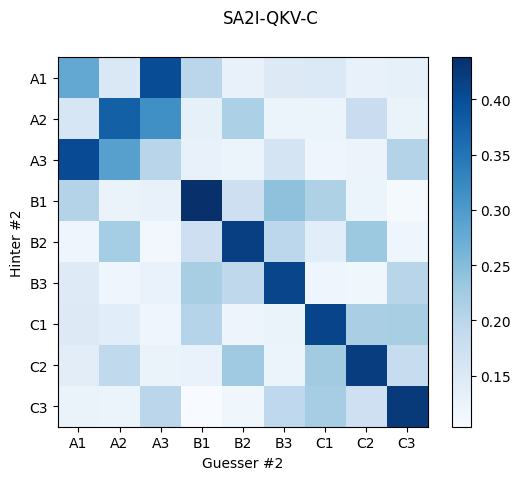

In [17]:
labels = [f"{char}{num}" for char in "ABC" for num in range(1, 4)]
fig, ax = plt.subplots()
cax = ax.imshow(conditional_prob, cmap='Blues')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel(f'Guesser #{guesser_idx}')
ax.set_ylabel(f'Hinter #{hinter_idx}')
fig.suptitle('SA2I-QKV-C') 
cbar = fig.colorbar(cax, ax=ax)

plt.show()

100%|██████████| 100/100 [00:20<00:00,  4.88it/s]
/tmp/ipykernel_79800/1092223517.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to not overlap with the colorbar


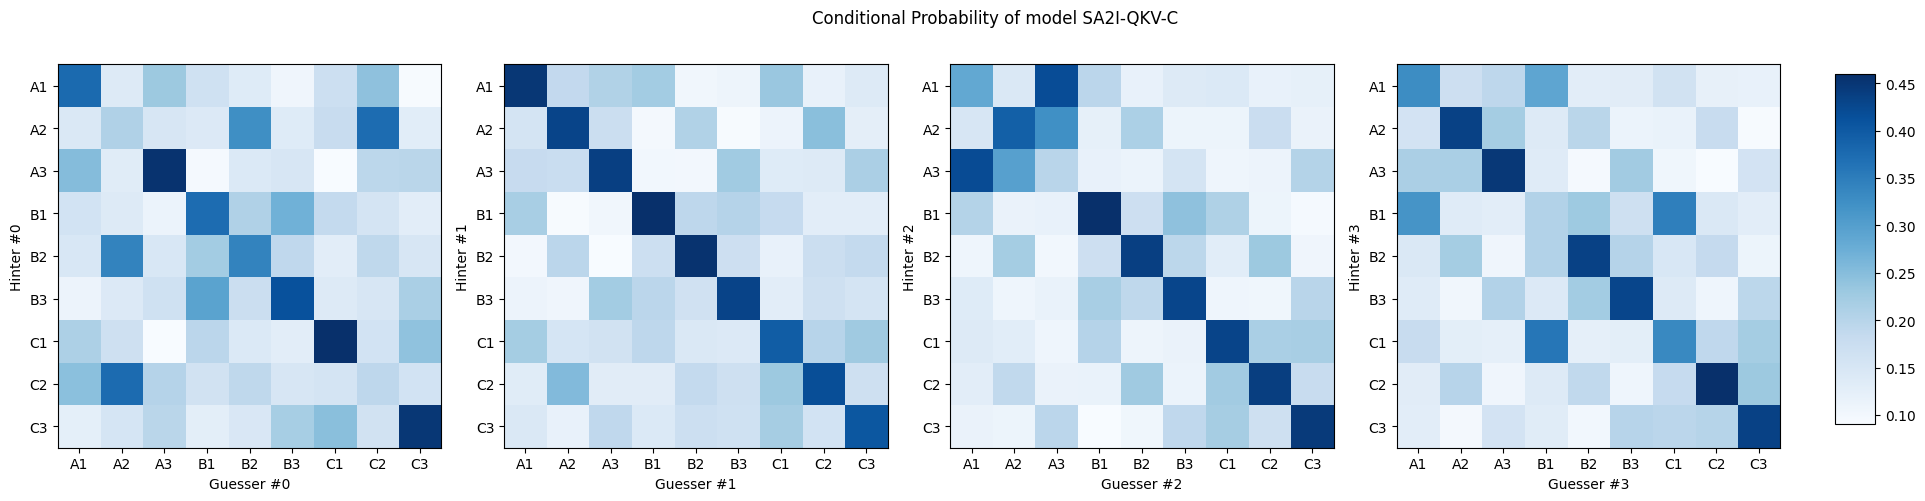

In [21]:
labels = [f"{char}{num}" for char in "ABC" for num in range(1, 4)]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns, and you can adjust figsize as needed

for i, ax in enumerate(axs):
    guesser_idx = i
    hinter_idx = i  # Replace with how you determine hinter_idx if it's different from guesser_idx
    h_tree = load_trainstate(f"result/2023-11-01-SA2I-QKV-C/hinter_{hinter_idx}")
    g_tree = load_trainstate(f"result/2023-11-01-SA2I-QKV-C/guesser_{guesser_idx}")

    t_state_h = create_train_state(hinter, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=h_tree["params"])
    t_state_g = create_train_state(guesser, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=g_tree["params"] )

    _, conditional_prob = play_eval(t_state_h, t_state_g, init_rng, config)
    cax = ax.imshow(conditional_prob, cmap='Blues')  # Use the i-th conditional probability matrix
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel(f'Guesser #{guesser_idx}')
    ax.set_ylabel(f'Hinter #{hinter_idx}')
    # ax.set_title(f'Subplot {i}')  # Or you can put any title you want

# Create an axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # This adds an axis for the colorbar
fig.colorbar(cax, cax=cbar_ax)
fig.suptitle('Conditional Probability of model SA2I-QKV-C') 
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to not overlap with the colorbar

plt.show()

In [6]:
agents = []
for i in range(config['num_agents']):
	h_tree = load_trainstate(f"result/2023-11-01-SA2I-QKV-C/hinter_{i}")
	g_tree = load_trainstate(f"result/2023-11-01-SA2I-QKV-C/guesser_{i}")
	t_state_h = create_train_state(hinter, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=h_tree["params"])
	t_state_g = create_train_state(guesser, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=g_tree["params"] )
	agents.append([t_state_h, t_state_g])

xp_result = xp_eval(agents, config)

100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


Hinter0, Guesser0, Reward: 0.6792799830436707


100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


Hinter0, Guesser1, Reward: 0.3193400204181671


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Hinter0, Guesser2, Reward: 0.31915998458862305


100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


Hinter0, Guesser3, Reward: 0.27421998977661133


100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


Hinter1, Guesser0, Reward: 0.32356002926826477


100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


Hinter1, Guesser1, Reward: 0.689520001411438


100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


Hinter1, Guesser2, Reward: 0.2930000126361847


100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


Hinter1, Guesser3, Reward: 0.35019999742507935


100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


Hinter2, Guesser0, Reward: 0.3287400007247925


100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


Hinter2, Guesser1, Reward: 0.2897399961948395


100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


Hinter2, Guesser2, Reward: 0.7196000218391418


100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Hinter2, Guesser3, Reward: 0.5016000270843506


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


Hinter3, Guesser0, Reward: 0.27646002173423767


100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


Hinter3, Guesser1, Reward: 0.3463999927043915


100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


Hinter3, Guesser2, Reward: 0.4961000084877014


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Hinter3, Guesser3, Reward: 0.6894599795341492


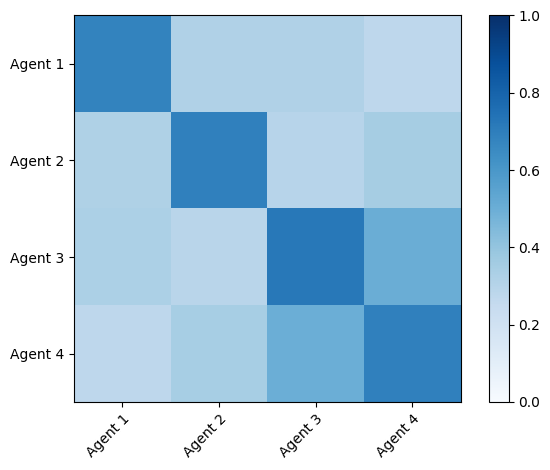

In [7]:
labels = [f"Agent {i}" for i in range(1, config["num_agents"]+1)]
fig, ax = plt.subplots()
cax = ax.imshow(xp_result, cmap='Blues', vmin=0, vmax=1)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
cbar = fig.colorbar(cax, ax=ax)

plt.tight_layout()
plt.show()

In [2]:
from models.SA2I import * 
model_test()

(256, 5)
